In [1]:
# importing the needed packages

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb
from sklearn.model_selection import cross_val_score

#feature engineering
from sklearn.feature_selection import mutual_info_regression
# ignoring warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
'''from google.colab import drive
drive.mount('/content/drive')'''

"from google.colab import drive\ndrive.mount('/content/drive')"

In [3]:
# Reading our datasets

training_data = pd.read_csv('train.csv')

test_data = pd.read_csv('test.csv')

# Exploring Data


In [4]:
training_data.head()

,id,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
0,0,I,1.5250,1.1750,0.3750,28.973189,12.728926,6.647958,8.348928,9
1,1,I,1.1000,0.8250,0.2750,10.418441,4.521745,2.324659,3.401940,8
2,2,M,1.3875,1.1125,0.3750,24.777463,11.339800,5.556502,6.662133,9
3,3,F,1.7000,1.4125,0.5000,50.660556,20.354941,10.991839,14.996885,11
4,4,I,1.2500,1.0125,0.3375,23.289114,11.977664,4.507570,5.953395,8


In [5]:
training_data.shape

(74051, 10)

In [6]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74051 entries, 0 to 74050
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              74051 non-null  int64  
 1   Sex             74051 non-null  object 
 2   Length          74051 non-null  float64
 3   Diameter        74051 non-null  float64
 4   Height          74051 non-null  float64
 5   Weight          74051 non-null  float64
 6   Shucked Weight  74051 non-null  float64
 7   Viscera Weight  74051 non-null  float64
 8   Shell Weight    74051 non-null  float64
 9   Age             74051 non-null  int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 5.6+ MB


In [7]:
training_data.duplicated().sum()

0

In [8]:
training_data.isna().sum()

id                0
Sex               0
Length            0
Diameter          0
Height            0
Weight            0
Shucked Weight    0
Viscera Weight    0
Shell Weight      0
Age               0
dtype: int64

##### No Null or duplicated values

In [9]:
training_data.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,74051.0,NaN,NaN,NaN,37025.0,21376.826729,0.0,18512.5,37025.0,55537.5,74050.0
Sex,74051,3,M,27084,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Length,74051.0,NaN,NaN,NaN,1.31746,0.287757,0.1875,1.15,1.375,1.5375,2.012815
Diameter,74051.0,NaN,NaN,NaN,1.024496,0.237396,0.1375,0.8875,1.075,1.2,1.6125
Height,74051.0,NaN,NaN,NaN,0.348089,0.092034,0.0,0.3,0.3625,0.4125,2.825
Weight,74051.0,NaN,NaN,NaN,23.385217,12.648153,0.056699,13.437663,23.799405,32.162508,80.101512
Shucked Weight,74051.0,NaN,NaN,NaN,10.10427,5.618025,0.028349,5.712424,9.90815,14.033003,42.184056
Viscera Weight,74051.0,NaN,NaN,NaN,5.058386,2.792729,0.042524,2.8633,4.989512,6.988152,21.54562
Shell Weight,74051.0,NaN,NaN,NaN,6.72387,3.584372,0.042524,3.96893,6.931453,9.07184,28.491248
Age,74051.0,NaN,NaN,NaN,9.967806,3.175189,1.0,8.0,10.0,11.0,29.0


In [10]:
training_data['Height'].value_counts()[0]

24

####  Height cannot be 0 so i will replace them with mean
####  There're outlier's


In [11]:
# i will drop the id coloumn as it's unnecessary
training_data.drop("id",inplace=True,axis=1)

In [12]:
training_data["Height"] = training_data["Height"].replace(0, training_data["Height"].mean())

In [13]:
training_data.describe()

,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
count,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000
mean,1.317460,1.024496,0.348202,23.385217,10.104270,5.058386,6.723870,9.967806
std,0.287757,0.237396,0.091820,12.648153,5.618025,2.792729,3.584372,3.175189
min,0.187500,0.137500,0.012500,0.056699,0.028349,0.042524,0.042524,1.000000
25%,1.150000,0.887500,0.300000,13.437663,5.712424,2.863300,3.968930,8.000000
50%,1.375000,1.075000,0.362500,23.799405,9.908150,4.989512,6.931453,10.000000
75%,1.537500,1.200000,0.412500,32.162508,14.033003,6.988152,9.071840,11.000000
max,2.012815,1.612500,2.825000,80.101512,42.184056,21.545620,28.491248,29.000000


<Axes: >

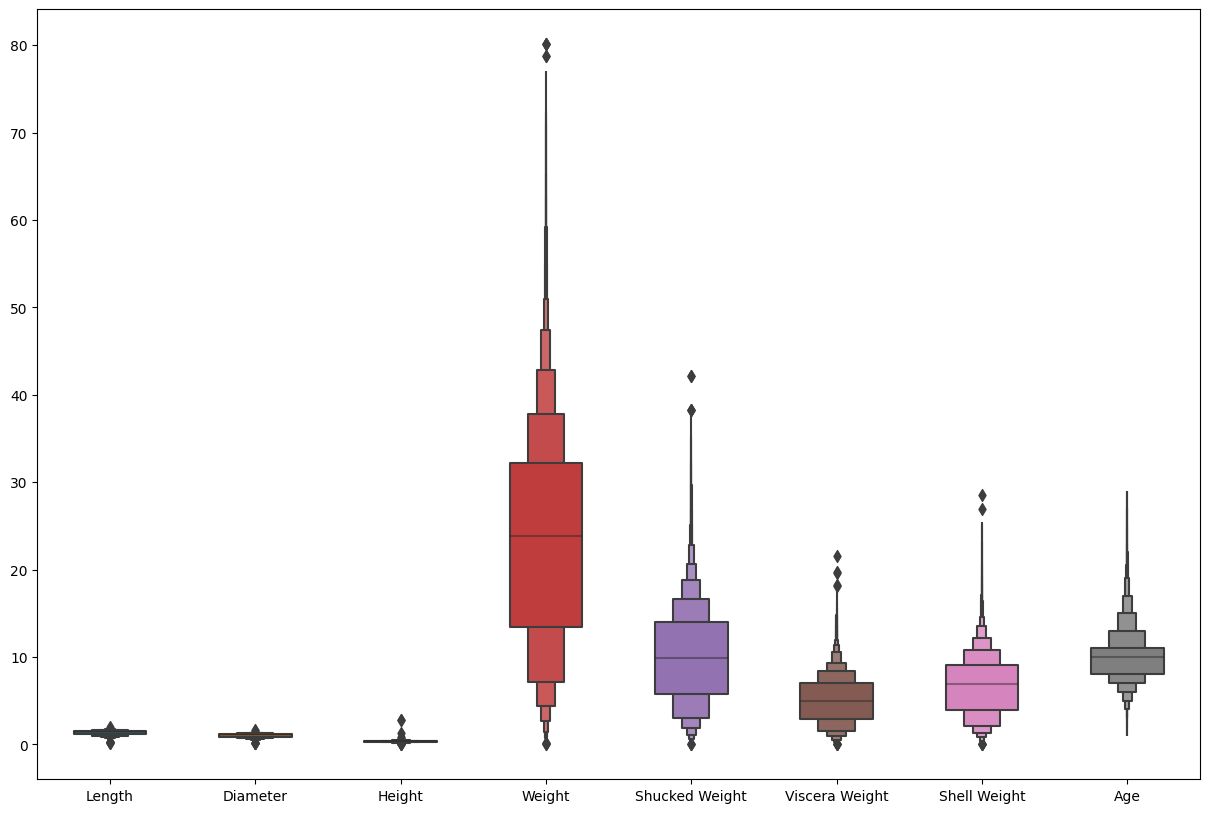

In [14]:

fig, ax = plt.subplots(figsize = (15, 10))
sns.boxenplot(data = training_data, width = 0.5, ax = ax)

#####  when i do search for ranges of ('Length', 'Diameter', 'Height', 'Weight', 'Shucked Weight','Viscera Weight', 'Shell Weight', 'Age') i found the outer values of each are normal according to different types of crabs ( i don't know if it's right) but decided to leave them

#### Grouping features for preprocessing

In [15]:
feature_list = [feature for feature in training_data.columns if not feature  == "Age"]
categorical_features= ['Sex']
numerical_features = list(set(feature_list) - set(categorical_features))

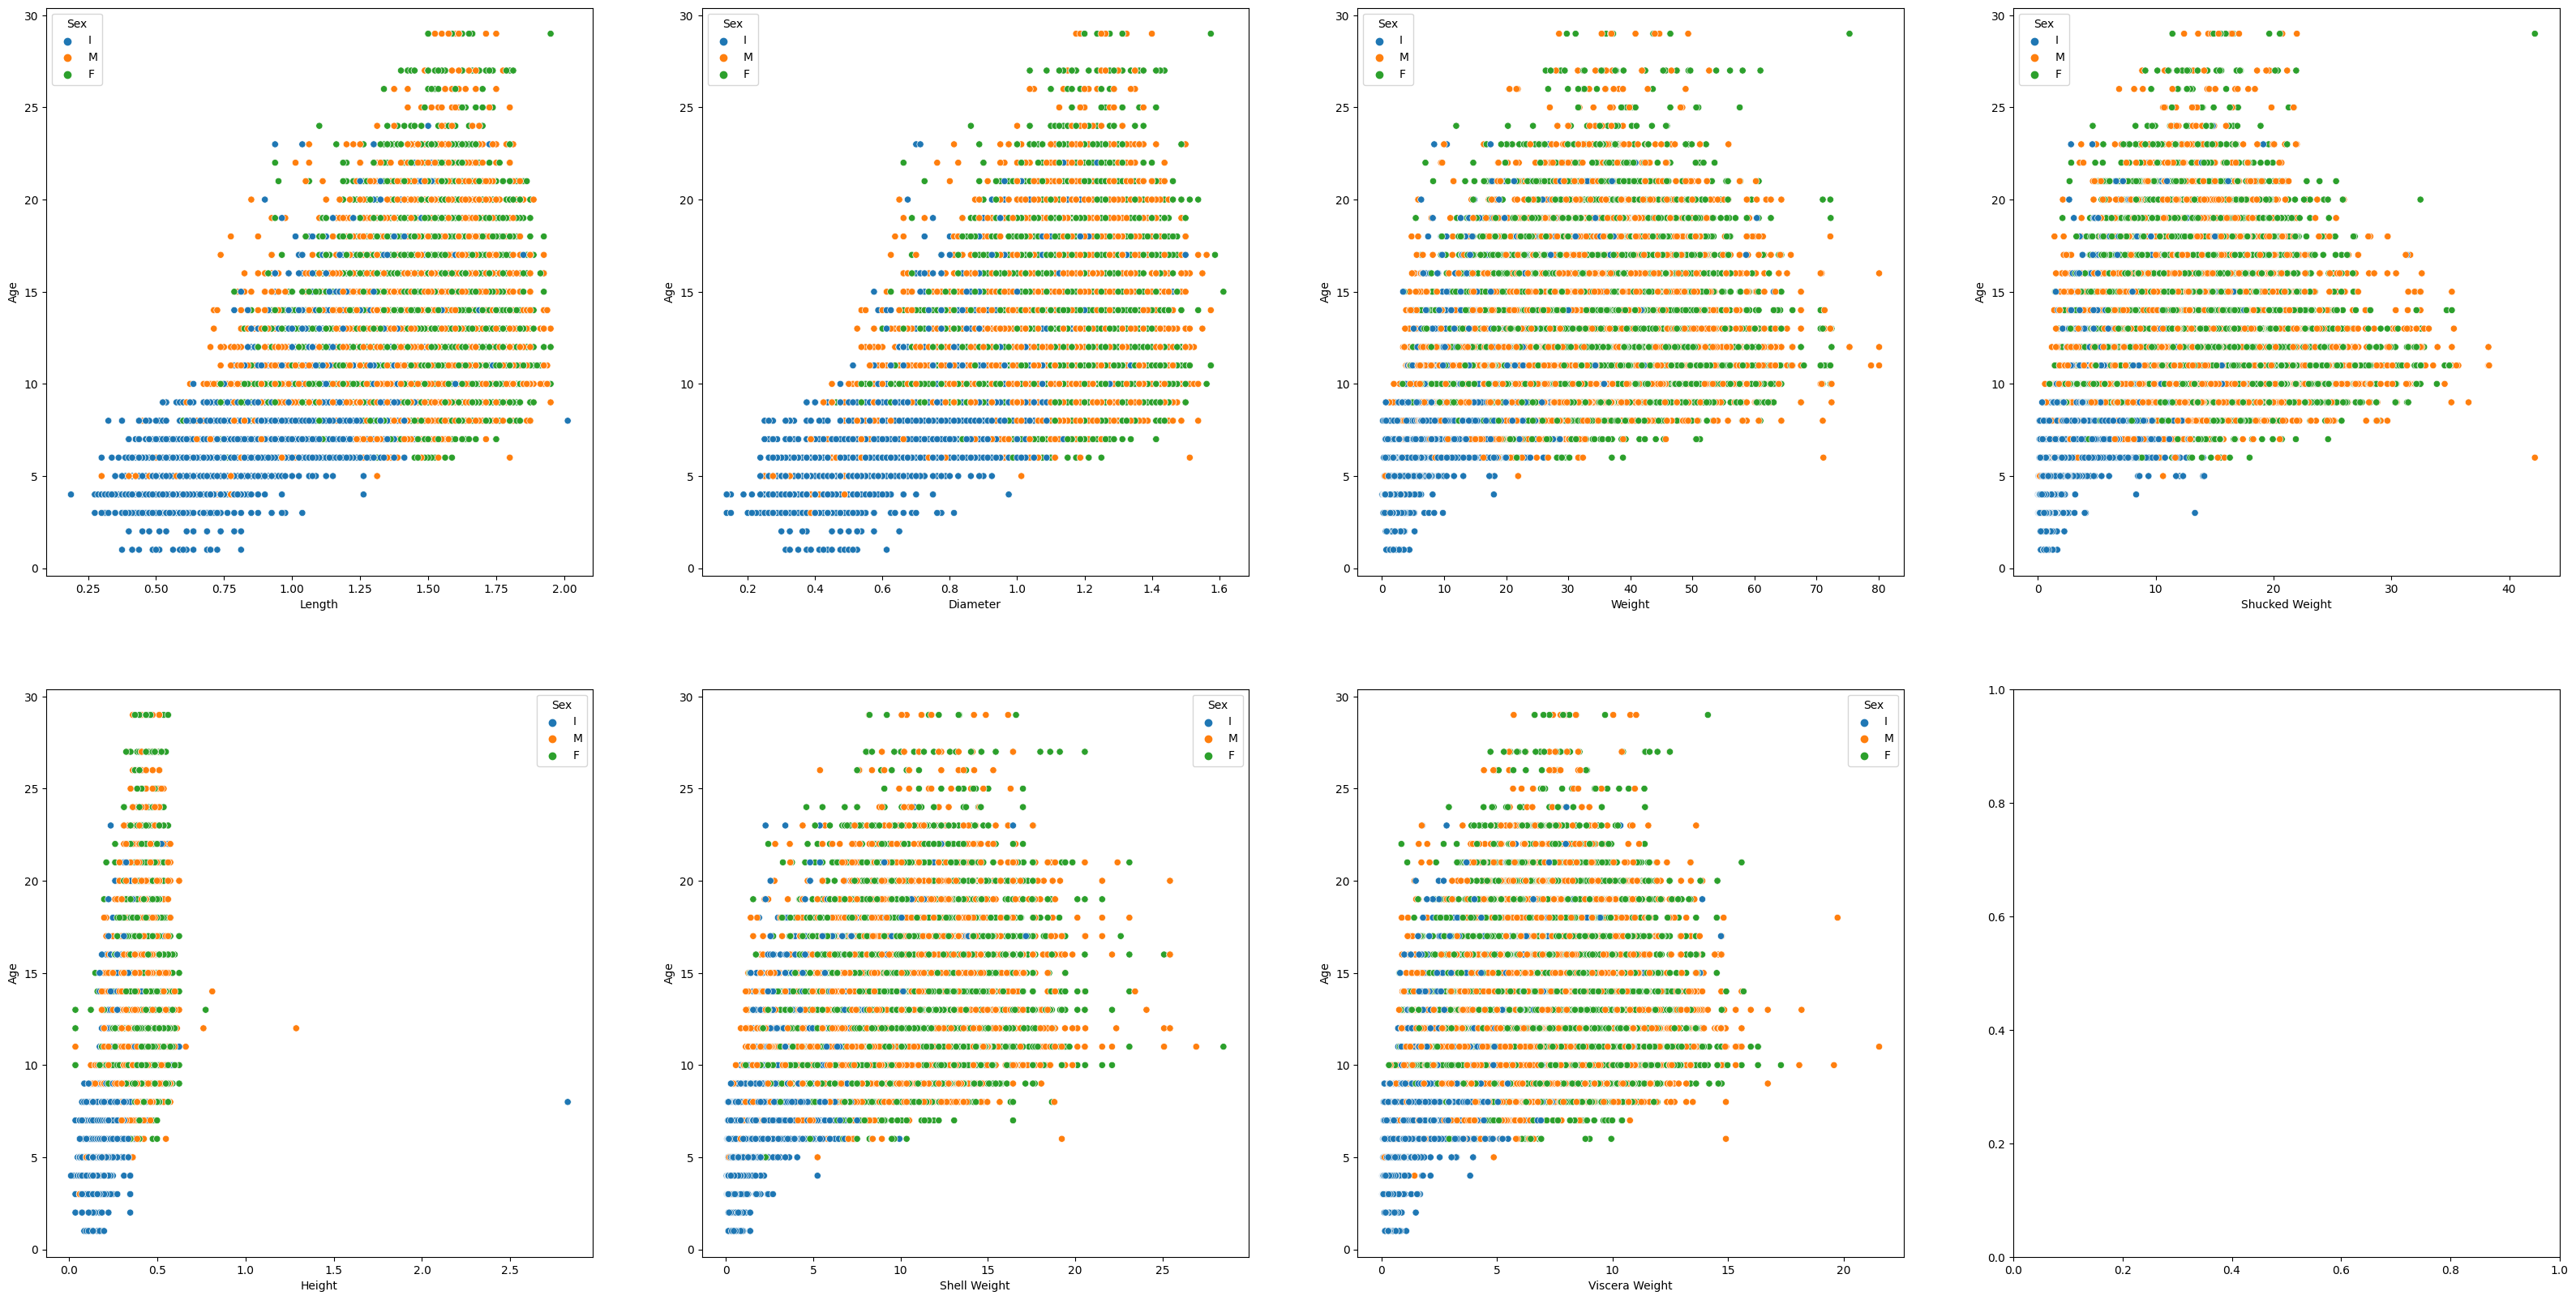

In [16]:
fig, ax = plt.subplots(2, 4, figsize=(40, 20))
for var, subplot in zip(numerical_features, ax.flatten()):
    sns.scatterplot(x=var, y='Age',  data=training_data, ax=subplot, hue = 'Sex' )

##### There are correlations between numerical_features and age
##### Sex I samples are younger and smaller

## let's see the correlation between attributes

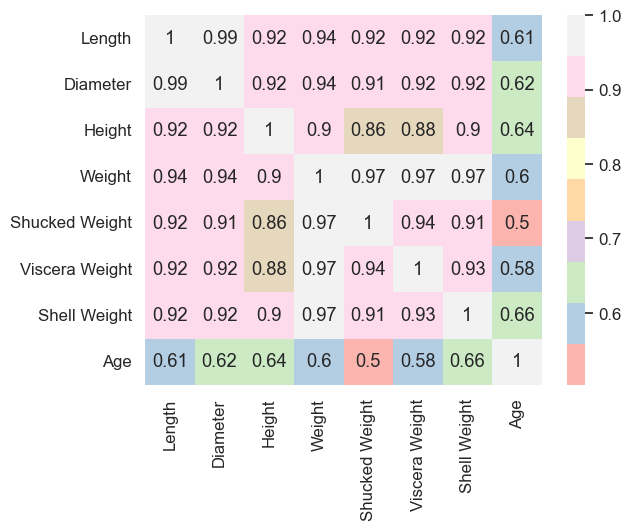

In [17]:
sns.set(font_scale=1.1)
sns.heatmap(training_data.corr(), annot = True,cmap="Pastel1")
plt.show()

#####  Determine the mutual information for numerical and categorical features

### feature Engineering

In [18]:
y= training_data['Age']

mutual_df = training_data[numerical_features]

mutual_info = mutual_info_regression(mutual_df, y, random_state=1)

mutual_info = pd.Series(mutual_info)
mutual_info.index = mutual_df.columns
pd.DataFrame(mutual_info.sort_values(ascending=False), columns = ["MI_score"] )

,MI_score
Shell Weight,0.561426
Weight,0.505244
Height,0.492266
Diameter,0.489018
Viscera Weight,0.486089
Length,0.477225
Shucked Weight,0.452163


In [19]:
mutual_df_categorical = training_data[categorical_features]
#categorical features must be encoded to get mutual information
for col in mutual_df_categorical:
    mutual_df_categorical[col], _ = mutual_df_categorical[col].factorize()
mutual_info = mutual_info_regression(mutual_df_categorical, y, random_state=1)

mutual_info = pd.Series(mutual_info)
mutual_info.index = mutual_df_categorical.columns
pd.DataFrame(mutual_info.sort_values(ascending=False), columns = ["Categorical_MI"] )

,Categorical_MI
Sex,0.2454


In [20]:

# Create a copy of the original data
new_training_data = training_data.copy()

# Create new features
new_training_data["volume"] = new_training_data["Height"] * new_training_data["Diameter"] * new_training_data["Length"]
new_training_data["total_weight"] = new_training_data["Shell Weight"] + new_training_data["Viscera Weight"] + new_training_data["Shucked Weight"]
new_training_data["shell_to_total_weight"] = new_training_data["Shell Weight"] / new_training_data["Weight"]
new_training_data["viscera_to_total_weight"] = new_training_data["Viscera Weight"] / new_training_data["Weight"]
new_training_data["shucked_to_total_weight"] = new_training_data["Shucked Weight"] / new_training_data["Weight"]

# Now, new_training_data contains the original columns plus the newly created features


In [21]:
new_features = ["volume",  'total_weight', 'shell_to_total_weight','viscera_to_total_weight','shucked_to_total_weight']

In [22]:
mutual_df = new_training_data[new_features]

mutual_info = mutual_info_regression(mutual_df, y, random_state=1)

mutual_info = pd.Series(mutual_info)
mutual_info.index = mutual_df.columns
pd.DataFrame(mutual_info.sort_values(ascending=False), columns = ["New_Feature_MI"] )

,New_Feature_MI
volume,0.513377
total_weight,0.486086
shucked_to_total_weight,0.213747
shell_to_total_weight,0.199781
viscera_to_total_weight,0.141720


##### Some new features have higher mutual information scores than the original ones. Let's observe their relations with the target

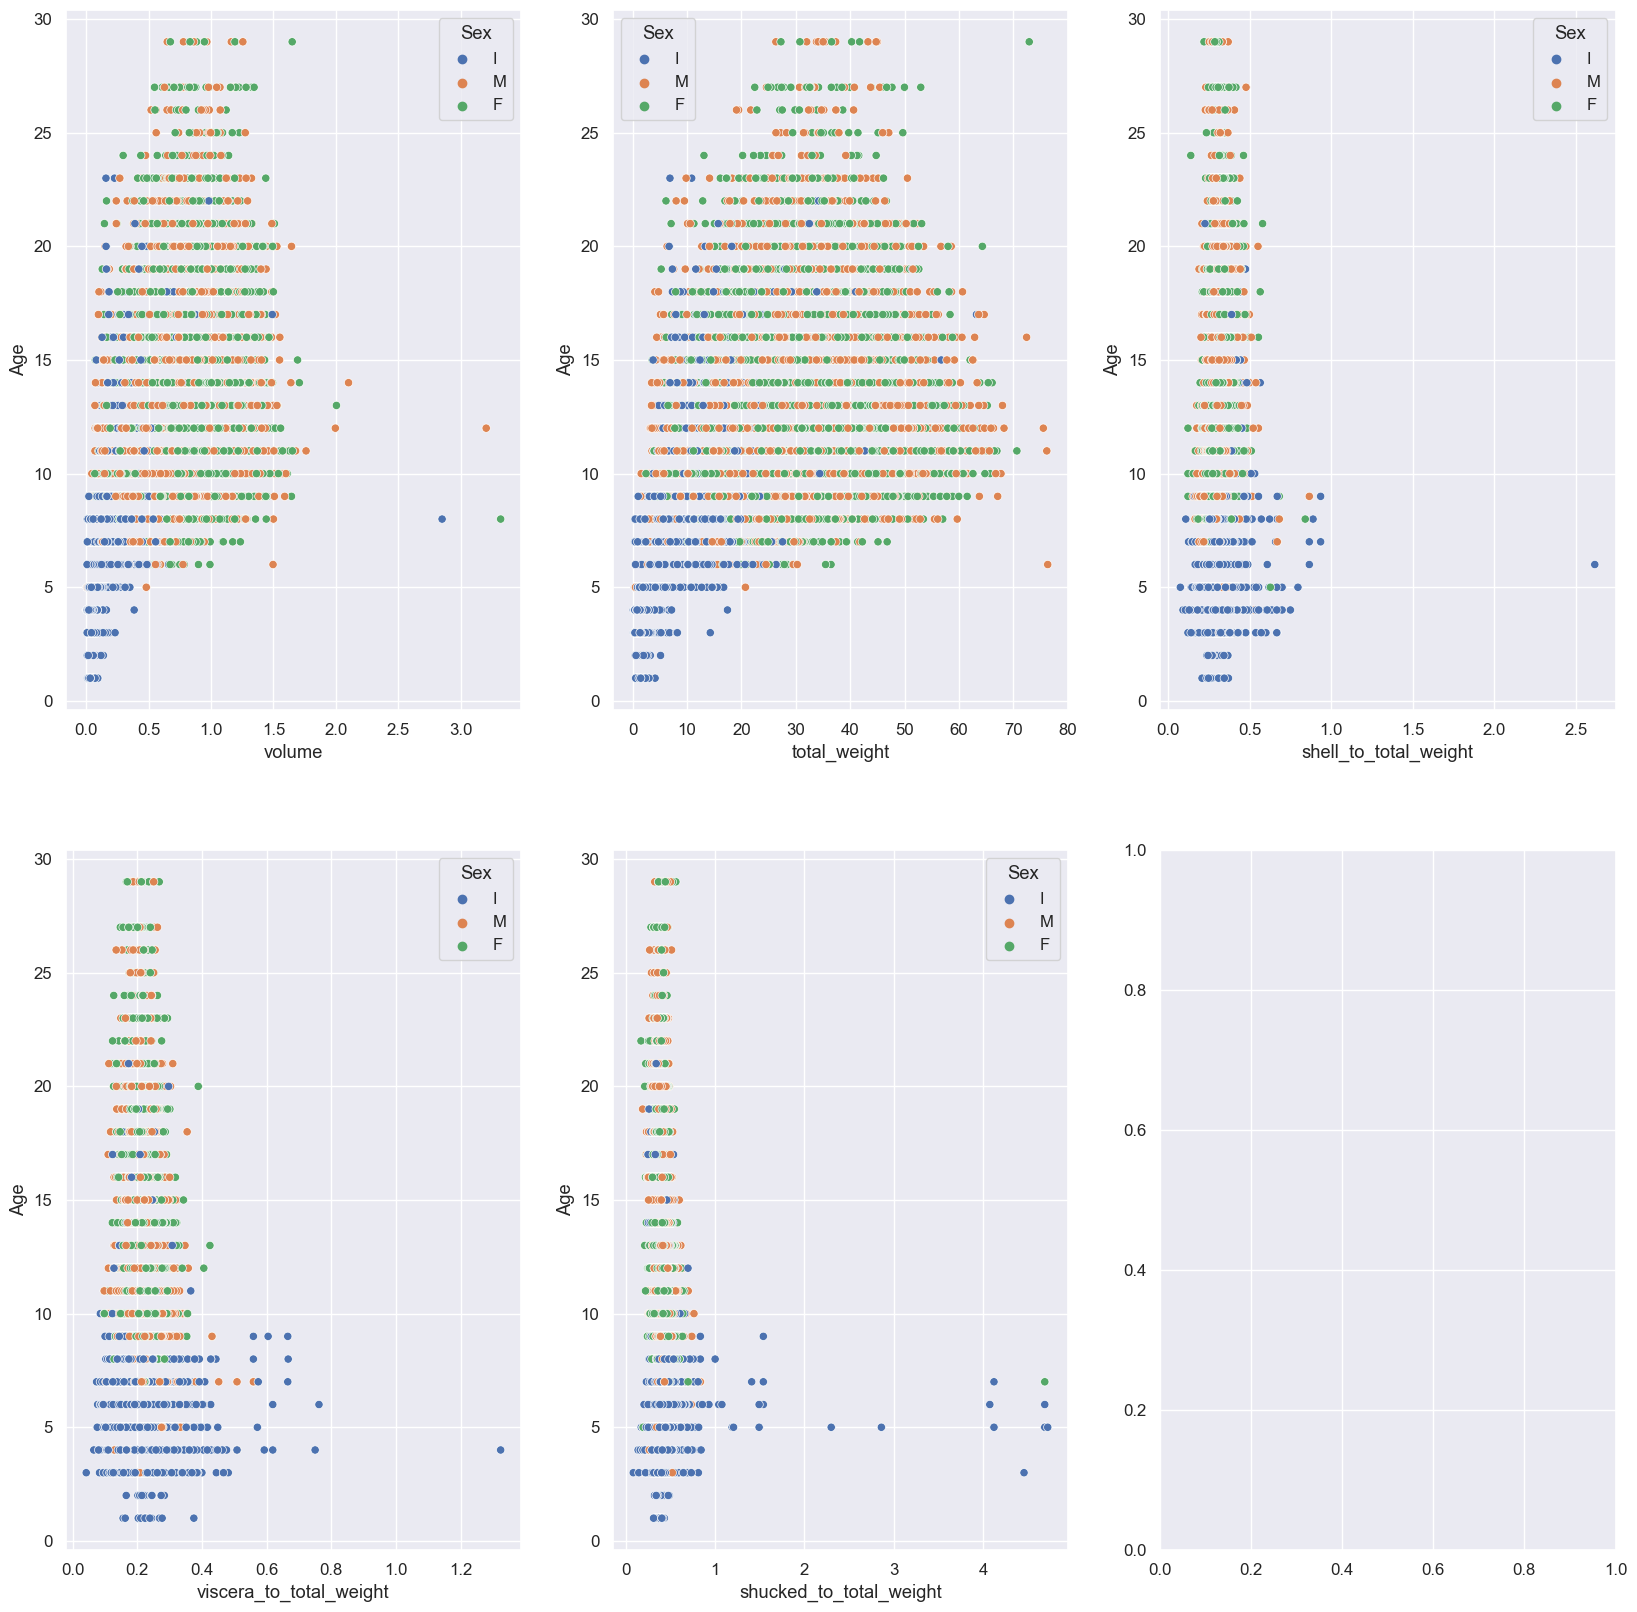

In [23]:
fig, ax = plt.subplots(2, 3, figsize=(20, 20))
for var, subplot in zip(new_features, ax.flatten()):
    sns.scatterplot(x=var, y='Age',  data=new_training_data, ax=subplot, hue = 'Sex')

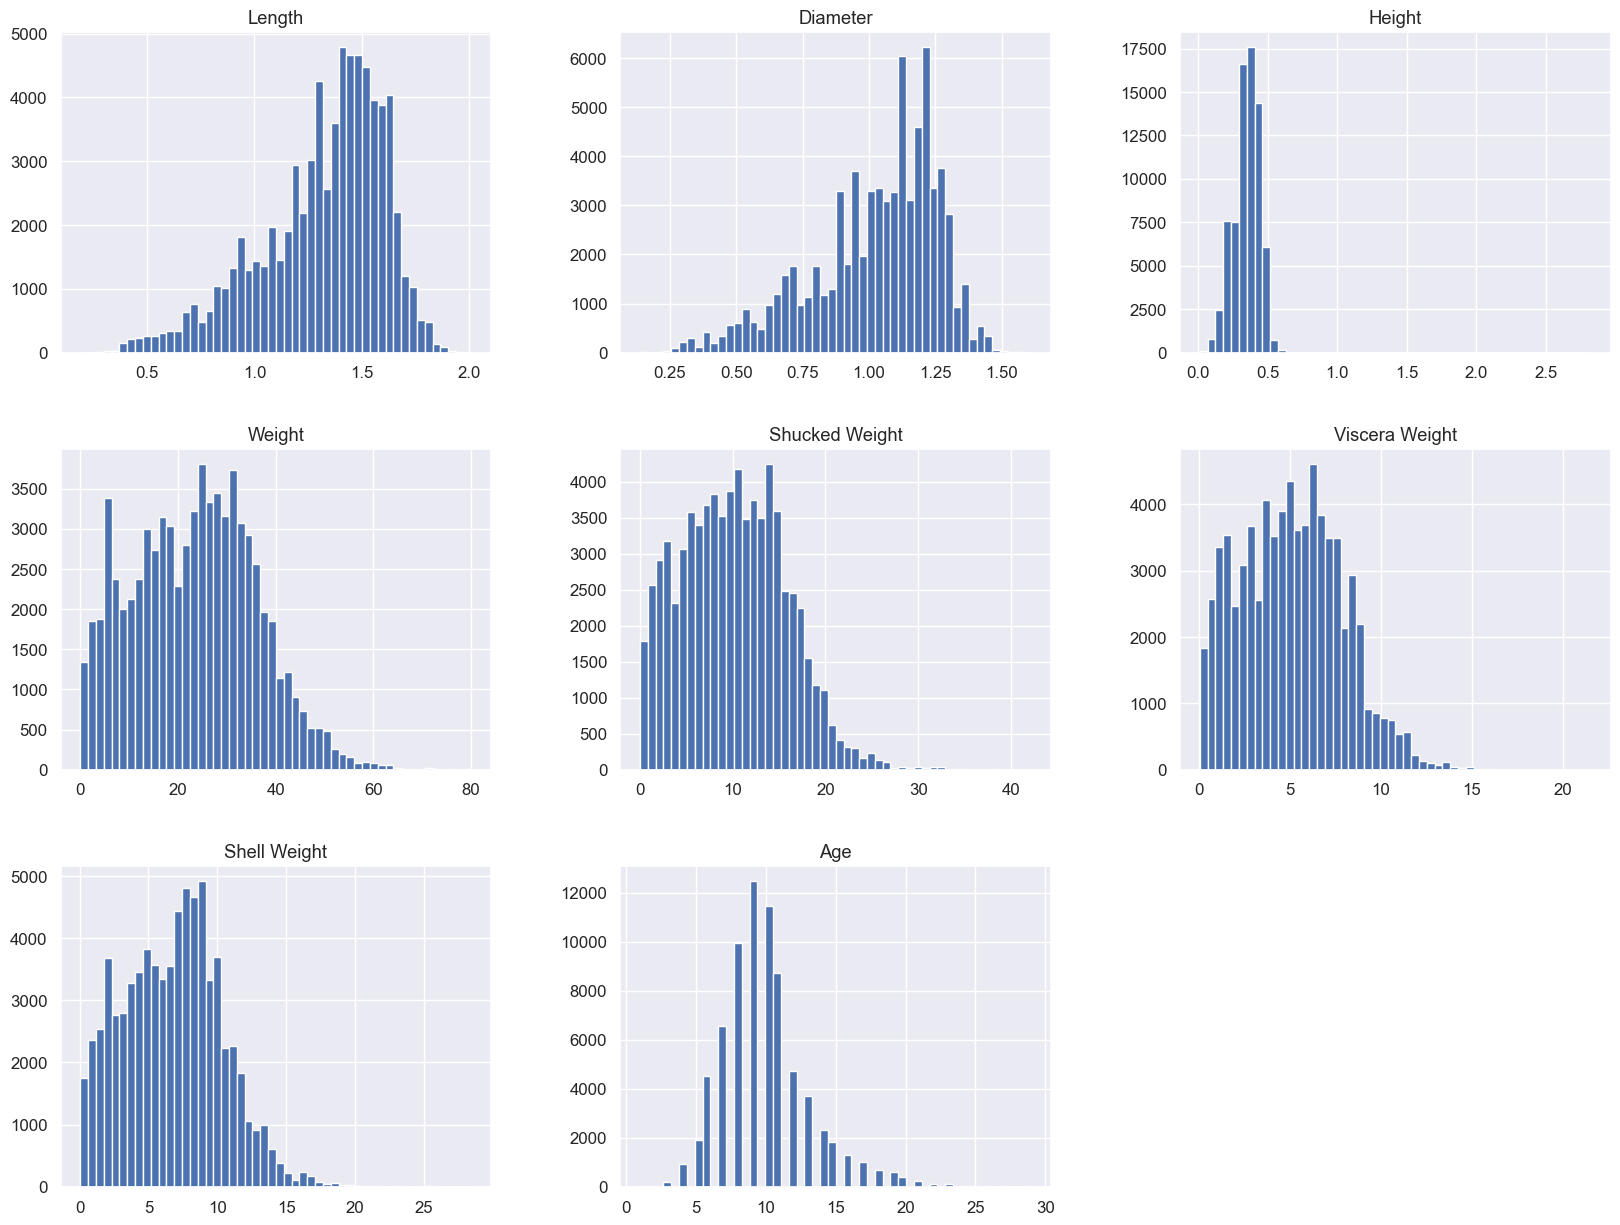

In [24]:
training_data.hist(bins=50, figsize=(20,15))
plt.show()

##### Data is skewed we will deal with that later

In [25]:
training_data

,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
0,I,1.5250,1.1750,0.3750,28.973189,12.728926,6.647958,8.348928,9
1,I,1.1000,0.8250,0.2750,10.418441,4.521745,2.324659,3.401940,8
2,M,1.3875,1.1125,0.3750,24.777463,11.339800,5.556502,6.662133,9
3,F,1.7000,1.4125,0.5000,50.660556,20.354941,10.991839,14.996885,11
4,I,1.2500,1.0125,0.3375,23.289114,11.977664,4.507570,5.953395,8
...,...,...,...,...,...,...,...,...,...
74046,F,1.6625,1.2625,0.4375,50.660556,20.680960,10.361742,12.332033,10
74047,I,1.0750,0.8625,0.2750,10.446791,4.323299,2.296310,3.543687,6
74048,F,1.4875,1.2000,0.4125,29.483480,12.303683,7.540967,8.079607,10
74049,I,1.2125,0.9625,0.3125,16.768729,8.972617,2.919999,4.280774,8


In [26]:
new_training_data

,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age,volume,total_weight,shell_to_total_weight,viscera_to_total_weight,shucked_to_total_weight
0,I,1.5250,1.1750,0.3750,28.973189,12.728926,6.647958,8.348928,9,0.671953,27.725811,0.288160,0.229452,0.439335
1,I,1.1000,0.8250,0.2750,10.418441,4.521745,2.324659,3.401940,8,0.249563,10.248344,0.326531,0.223129,0.434014
2,M,1.3875,1.1125,0.3750,24.777463,11.339800,5.556502,6.662133,9,0.578848,23.558435,0.268879,0.224256,0.457666
3,F,1.7000,1.4125,0.5000,50.660556,20.354941,10.991839,14.996885,11,1.200625,46.343665,0.296027,0.216970,0.401791
4,I,1.2500,1.0125,0.3375,23.289114,11.977664,4.507570,5.953395,8,0.427148,22.438629,0.255630,0.193548,0.514303
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74046,F,1.6625,1.2625,0.4375,50.660556,20.680960,10.361742,12.332033,10,0.918271,43.374735,0.243425,0.204533,0.408226
74047,I,1.0750,0.8625,0.2750,10.446791,4.323299,2.296310,3.543687,6,0.254977,10.163296,0.339213,0.219810,0.413840
74048,F,1.4875,1.2000,0.4125,29.483480,12.303683,7.540967,8.079607,10,0.736312,27.924257,0.274038,0.255769,0.417308
74049,I,1.2125,0.9625,0.3125,16.768729,8.972617,2.919999,4.280774,8,0.364697,16.173390,0.255283,0.174134,0.535080


### Preprocessor pipeline

In [27]:


class FeatureCreator(BaseEstimator, TransformerMixin):
    def __init__(self, add_attributes=True):
        self.add_attributes = add_attributes
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if self.add_attributes:
            X_copy = X.copy()
            X_copy["volume"] = X_copy["Height"] * X_copy["Diameter"] * X_copy["Length"]
            X_copy["total_weight"] = X_copy["Shell Weight"] + X_copy["Viscera Weight"] + X_copy["Shucked Weight"]
            X_copy["shell_to_total_weight"] = X_copy["Shell Weight"] / X_copy["Weight"]
            X_copy["viscera_to_total_weight"] = X_copy["Viscera Weight"] / X_copy["Weight"]
            X_copy["shucked_to_total_weight"] = X_copy["Shucked Weight"] / X_copy["Weight"]
            return X_copy
        else:
            return X  # Return the original DataFrame when add_attributes is False


feature_creator_transformer = FunctionTransformer(FeatureCreator().transform)




In [28]:

numerical_transformer = Pipeline(steps=[
    #('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    
])

In [29]:
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [30]:
#identify skewed features
skewnes = training_data[numerical_features].select_dtypes(exclude=['object']).skew().sort_values(ascending=False)
skewnes = pd.DataFrame({'Skew' : skewnes})
skewnes


,Skew
Shucked Weight,0.349472
Viscera Weight,0.286383
Shell Weight,0.277459
Weight,0.231465
Height,0.101156
Diameter,-0.812866
Length,-0.844377


In [31]:
#List them to preporocessing purpose
skewed_features = ['Diameter', 'Length']

In [32]:
#pipeline for skeweness
skewness_transformer = Pipeline(steps=[

    ('PowerTransformer', PowerTransformer( method='yeo-johnson', standardize=True))
])

In [ ]:
#pipeline for skeweness
skewness_transformer = Pipeline(steps=[

    ('PowerTransformer', PowerTransformer( method='yeo-johnson', standardize=True))
])

In [33]:
# preprocessor
preprocessor = ColumnTransformer(remainder=numerical_transformer,
    transformers=[
        ('skewness_transformer', skewness_transformer, skewed_features),
        ('categorical_transformer', categorical_transformer, categorical_features),
        ('creator', feature_creator_transformer, numerical_features)  # Use the transformed numerical features
    ])

preprocessor

ColumnTransformer(remainder=Pipeline(steps=[('scaler', StandardScaler())]),
                  transformers=[('skewness_transformer',
                                 Pipeline(steps=[('PowerTransformer',
                                                  PowerTransformer())]),
                                 ['Diameter', 'Length']),
                                ('categorical_transformer',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Sex']),
                                ('creator',
                                 FunctionTransformer(func=<bound method FeatureCreator.transform of FeatureCreator()>),
                                 ['Length', 'Diameter', 'Weight',
                                  'Shucked Weight', 'Height', 'Shell Weight',
                                  'Viscera Weight'])])

In [34]:
full_pipeline = Pipeline(steps=[

    ('preprocessor', preprocessor),
])

In [35]:
X = training_data.drop('Age', axis=1)
y = training_data['Age']

In [36]:
X_preproccessed = full_pipeline.fit_transform(X)

In [37]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import (GridSearchCV, KFold, train_test_split )

x_train, x_val, y_train, y_val= train_test_split(X_preproccessed, y, test_size=0.2, random_state=42)



In [38]:
from sklearn.linear_model import LinearRegression

regr = LinearRegression()

regr.fit(x_train, y_train)
train_score = regr.predict(x_train)
print("MAE on training set:", mean_absolute_error(y_train, train_score))

cv_scores = cross_val_score(regr, x_train, y_train, cv=5, scoring='neg_mean_absolute_error')
cv_mae = -1 * cv_scores.mean()
print("MAE on cross-validation set:", cv_mae)

val_pred = regr.predict(x_val)
val_mae = mean_absolute_error(val_pred, y_val)
print("MAE on test set:", val_mae)

MAE on training set: 1.4706509232694163
MAE on cross-validation set: 1.4709672466632555
MAE on test set: 1.4770010570261614


In [39]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(max_features=2, n_estimators=50, random_state=42)
rf.fit(x_train, y_train)
train_score = rf.predict(x_train)
print("MAE on training set:", mean_absolute_error(y_train, train_score))


cv_scores = cross_val_score(rf, x_train, y_train, cv=5, scoring='neg_mean_absolute_error')
cv_mae = -1 * cv_scores.mean()
print("MAE on cross-validation set:", cv_mae)

val_pred = rf.predict(x_val)
val_mae = mean_absolute_error(val_pred, y_val)
print("MAE on test set:", val_mae)

MAE on training set: 0.5423885887913571
MAE on cross-validation set: 1.4469253882511817
MAE on test set: 1.443302950509756


In [40]:
from xgboost import XGBRegressor

XGB = XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)

XGB.fit(x_train, y_train)

train_score = XGB.predict(x_train)

print("MAE on training set:", mean_absolute_error(y_train, train_score))
cv_scores = cross_val_score(rf, x_train, y_train, cv=5, scoring='neg_mean_absolute_error')
cv_mae = -1 * cv_scores.mean()
print("MAE on cross-validation set:", cv_mae)

val_pred = rf.predict(x_val)
val_mae = mean_absolute_error(val_pred, y_val)
print("MAE on test set:", val_mae)


MAE on training set: 0.814152569037527
MAE on cross-validation set: 1.4469253882511817
MAE on test set: 1.443302950509756


In [41]:
from lightgbm import LGBMRegressor

lgbm = LGBMRegressor(learning_rate=0.01, max_depth=6, num_iterations=500,
              random_state=42,num_leaves=31)

lgbm.fit(x_train, y_train)

train_score = lgbm.predict(x_train)
print("MAE on training set:", mean_absolute_error(y_train, train_score))

cv_scores = cross_val_score(lgbm, x_train, y_train, cv=5, scoring='neg_mean_absolute_error')
cv_mae = -1 * cv_scores.mean()
print("MAE on cross-validation set:", cv_mae)

val_pred = lgbm.predict(x_val)
val_mae = mean_absolute_error(val_pred, y_val)
print("MAE on test set:", val_mae)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003568 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2844
[LightGBM] [Info] Number of data points in the train set: 59240, number of used features: 17
[LightGBM] [Info] Start training from score 9.970172
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

In [42]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor()
knn.fit(x_train, y_train)

train_score = knn.predict(x_train)
print("MAE on training set:", mean_absolute_error(y_train, train_score))

cv_scores = cross_val_score(knn, x_train, y_train, cv=5, scoring='neg_mean_absolute_error')
cv_mae = -1 * cv_scores.mean()
print("MAE on cross-validation set:", cv_mae)

val_pred = knn.predict(x_val)
val_mae = mean_absolute_error(y_val, val_pred)
print("MAE on test set:", val_mae)

MAE on training set: 1.2582984469952736
MAE on cross-validation set: 1.543436866981769
MAE on test set: 1.5381810816285193


In [43]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4)
    {'n_estimators': [5, 25, 50], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3)
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)


grid_search = GridSearchCV(forest_reg, param_grid, cv=2,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

grid_search.fit(x_train, y_train)

GridSearchCV(cv=2, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [5, 25, 50]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [44]:
grid_search.best_params_

{'max_features': 2, 'n_estimators': 50}

In [45]:
grid_search.best_estimator_

RandomForestRegressor(max_features=2, n_estimators=50, random_state=42)

In [46]:


param_grid = [
    {'n_estimators': [100, 200, 500],
        'learning_rate': [0.01, 0.1, 0.3],
        'max_depth': [3, 6, 18]
    },
  ]

XGP_reg = XGBRegressor(random_state=42)

# train across 2 folds, that's a total of (12+6)*2=36 rounds of training
grid_search = GridSearchCV(XGP_reg, param_grid, cv=2,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

grid_search.fit(x_train, y_train)

GridSearchCV(cv=2,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=42, ...),
             param_grid=[{'learning_rate': [0.01, 0.1, 0.3],
                          'max_depth': [3, 6, 18],
                          'n_estimators': [100, 200, 500]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [47]:
grid_search.best_params_

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}

In [48]:
grid_search.best_estimator_

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=200, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [49]:
param_grid = {
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 6, 18],
    'num_iterations': [500, 700, 900], 
}


lgb_model = lgb.LGBMRegressor(random_state=42)


grid_search = GridSearchCV(lgb_model, param_grid, cv=2,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

# Fit the grid search to the data
grid_search.fit(x_train, y_train)


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003455 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2828
[LightGBM] [Info] Number of data points in the train set: 29620, number of used features: 17
[LightGBM] [Info] Start training from score 9.992134
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

GridSearchCV(cv=2, estimator=LGBMRegressor(random_state=42),
             param_grid={'learning_rate': [0.01, 0.1, 0.3],
                         'max_depth': [3, 6, 18],
                         'num_iterations': [500, 700, 900]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [50]:
grid_search.best_params_

{'learning_rate': 0.01, 'max_depth': 6, 'num_iterations': 500}

In [51]:
grid_search.best_estimator_

LGBMRegressor(learning_rate=0.01, max_depth=6, num_iterations=500,
              random_state=42)

In [52]:
x_test= test_data

In [53]:
x_test.shape

(49368, 9)

In [54]:
submition= pd.DataFrame()
submition['id']= test_data.index
submition['id'] = submition['id'] + 74051
submition= submition.set_index('id')

In [55]:

x_test = full_pipeline.transform(x_test)



In [56]:
test_pred = lgbm.predict(x_test)

reshaped= np.array(test_pred).reshape(-1,1)

submition['Age']= reshaped

reshaped

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


array([[ 7.505378  ],
       [ 7.90229715],
       [10.79100856],
       ...,
       [13.20071819],
       [10.23881322],
       [12.00675766]])

In [57]:

submition.to_csv('submitionn.csv')